In [7]:
import tensorflow as tf
import numpy as np
import math
from typing import Sequence
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from librosa._typing import _STFTPad
import time, random

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------
# Config (edit to your needs)
# ------------------------------
SR = 22050
NFFT = 1024
HOP = 512
NMELS = 128
FMIN = 200.0
FMAX = 8000.0

FRAME_LENGTH = NFFT
FRAME_STEP = HOP

LOG_EPS = 1e-6

PAR = tf.data.AUTOTUNE
PREF = 2

# Different functions for each dataset
def load_birdclef(audio_root, path, target, folds=5, min_per_class = 10):
    df = pd.read_csv(path)
    
    df["path"] = audio_root + "/" + df["primary_label"] + "/" + df["filename"]
    
    # Sanity check
    dups = df['path'].duplicated().sum()  # or 'filename'
    print("Duplicate file rows:", dups)
    
    # Optional: drop rare classes (keeps CV stable)
    if min_per_class > 1:
        keep_labels = df["primary_label"].value_counts()
        keep_labels = keep_labels[keep_labels >= min_per_class].index
        df = df[df["primary_label"].isin(keep_labels)].reset_index(drop=True)

    # Generate the binary labels
    labels = (df['primary_label'] == target).astype(int).values
    groups = df['primary_label']
    
    # Get k folds
    skf = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=42)
    splits = []
    for tr, va in skf.split(df, y=labels, groups=groups):
        splits.append({
            "train":tr, 
            "val": va, 
            "train_size": len(tr),
            "val_size": len(va),
            "train_pos_ratio": labels[tr].mean(),
            "val_pos_ratio": labels[va].mean(),
            }
        )
    
    return df, splits

def build_file_lists(df, split, target):
    # This function creates lists of filepaths for the split
    # This results in 4 lists, train_pos, train_neg, val_pos and val_neg
    tr_idx, va_idx = split["train"], split["val"]
    train = df.iloc[tr_idx]; val = df.iloc[va_idx]
    
    pos_train = train[train.primary_label == target]["path"].tolist()
    neg_train = train[train.primary_label != target]["path"].tolist()

    pos_val = val[val.primary_label == target]["path"].tolist()
    neg_val = val[val.primary_label != target]["path"].tolist()
    return (pos_train, neg_train), (pos_val, neg_val)

def plan_epoch(n_pos_train, pos_exposures=1.0, neg_ratio=1.0, batch_size=32, pos_ratio=0.5):
    # This function plans the amount of positive and negative samples per training
    # epoch. This ensures that we don't train on all the negatives and we can 
    # tune the amount of positives that we see
    
    # n_pos_train: unique positive files in the train split
    # pos_exposures: how many times you want to see each positive per epoch on average (1.0 ≈ once)
    # neg_ratio: negatives per positive overall (1.0 = 1:1, 2.0 = twice as many negs)
    # pos_ratio: within-batch sampling weight for positives (0.5 = 50/50)
    
    P_pos = math.ceil(n_pos_train * pos_exposures)
    # keep the global neg:pos = neg_ratio (independent of within-batch pos_ratio)
    P_neg = math.ceil(P_pos * neg_ratio)

    total_examples = P_pos + P_neg
    steps_per_epoch = math.ceil(total_examples / batch_size)
    return P_pos, P_neg, steps_per_epoch
   

os.chdir("/home/joris/Thesis/new_attempt")

target = "rucwar"

birdclef_df, splits = load_birdclef("datasets/birdclef_2021/train_short_audio", "datasets/birdclef_2021/train_metadata.csv", target=target, folds=5)

split = splits[0]  # pick a fold

# File lists for that fold
train = birdclef_df.iloc[split["train"]]
val   = birdclef_df.iloc[split["val"]]
(pos_tr, neg_tr), (pos_va, neg_va) = build_file_lists(birdclef_df, split, target)

print("Dataset Information")
print(f"Training: Pos: {len(pos_tr)}, Neg: {len(neg_tr)}")
print(f"Validation: Pos: {len(pos_va)}, Neg: {len(neg_va)}")

TRAIN_NEG_RATIO = 2
VAL_NEG_RATIO = 2

BATCH_SIZE = 32

# plan the budgets for the training
P_pos, P_neg, steps = plan_epoch(n_pos_train=len(pos_tr),
                                 pos_exposures=1.0,   # ~see each positive once/epoch
                                 neg_ratio=TRAIN_NEG_RATIO,       # 1:1 overall
                                 batch_size=BATCH_SIZE)

print(f"Positive Samples: {P_pos}, Negative Samples: {P_neg}, steps: {steps}")

neg_tr_sample = random.sample(neg_tr, P_neg)
neg_va_sample = random.sample(neg_va, len(pos_va) * VAL_NEG_RATIO)

print(split)

print(pos_tr)
print(neg_tr_sample)
print(pos_va)
print(neg_va_sample)


TF: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Duplicate file rows: 0
Dataset Information
Training: Pos: 154, Neg: 50205
Validation: Pos: 0, Neg: 12490
Positive Samples: 154, Negative Samples: 308, steps: 15
{'train': array([    0,     1,     2, ..., 62739, 62740, 62741]), 'val': array([  593,   594,   595, ..., 62846, 62847, 62848]), 'train_size': 50359, 'val_size': 12490, 'train_pos_ratio': 0.003058043249468814, 'val_pos_ratio': 0.0}
['datasets/birdclef_2021/train_short_audio/rucwar/XC132907.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC133150.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC133467.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC134440.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC135356.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC136316.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC147181.ogg', 'datasets/birdclef_2021/train_short_audio/rucwar/XC147382.ogg', 'datasets/

Raw:  (197922,)
Noise:  (115564,)
Fade:  (115564,)
Band Filter:  (115564,)
DB Mel Spectrogram:  (452, 128)
0.37.1


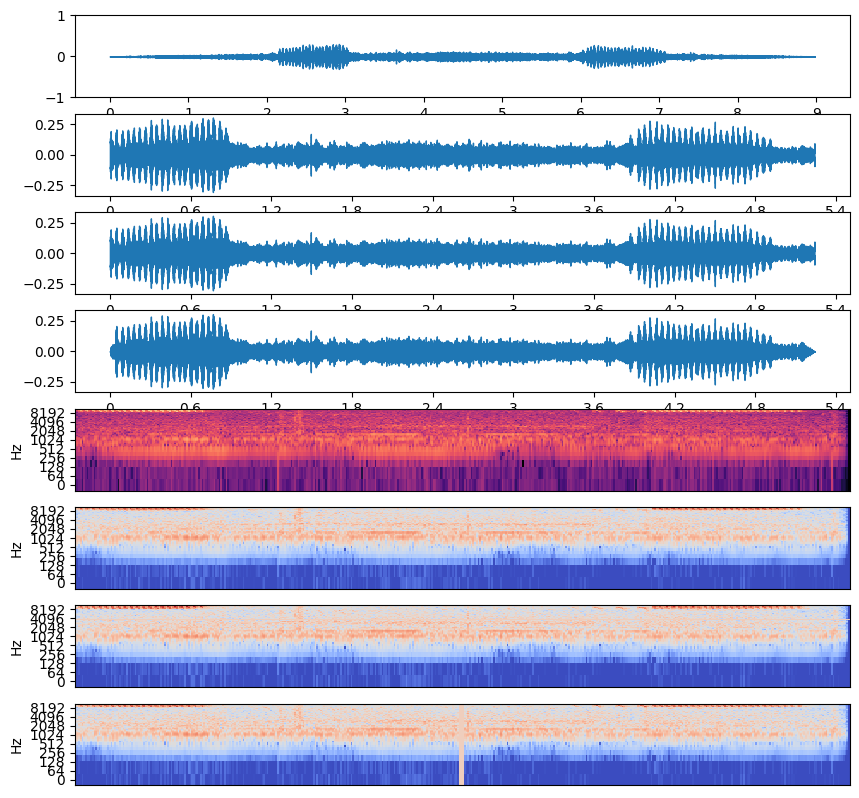

In [ ]:
# Data examination
import tensorflow_io as tfio
SAMPLE_RATE = 16000
SPECTROGRAM_SECONDS = 3
FILL_TYPE = "tile" # pad | tile

# Load audio file as tensor
audio, sr = librosa.load(pos_tr[3], sr=SAMPLE_RATE)
# audio_file = tfio.audio.AudioIOTensor(pos_tr[4])

# Remove last dimension
waveform = audio
print("Raw: ", waveform.shape)

fig, axs = plt.subplots(8, figsize=(10, 10))

axs[0].set_ylim(-1, 1)

librosa.display.waveshow(waveform, ax=axs[0])

# Trim the noise from the audio
position = tfio.audio.trim(waveform, axis=0, epsilon=0.1)

start = position[0]
stop = position[1]

processed = waveform[start:stop]
print("Noise: ", processed.shape)

librosa.display.waveshow(processed, ax=axs[1])

processed = waveform[start:stop]
frame_count = tf.shape(processed)
# Calculate end padding
if (frame_count < SR):
    print("To short")
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(1, int((SAMPLE_RATE * SPECTROGRAM_SECONDS) / frame_count))
        processed = tf.tile(processed, [repeats])
else:
    padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
    processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    
librosa.display.waveshow(processed.numpy(), ax=axs[2])

# Fade in and out
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")
librosa.display.waveshow(fade.numpy(), ax=axs[3])
print("Fade: ", fade.get_shape())

# Band filter
from scipy import signal
b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
band_filter = tf.cast(tf.convert_to_tensor(signal.lfilter(b, a, fade)), tf.float32)
print("Band Filter: ", band_filter.get_shape())

# Spectrograms
spectrogram = tfio.audio.spectrogram(fade, nfft=1024, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
print("DB Mel Spectrogram: ", db_mel_spectrogram.get_shape())

librosa.display.specshow(tf.transpose(db_mel_spectrogram).numpy(), ax=axs[4], y_axis="log", cmap="magma")

spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

librosa.display.specshow(tf.transpose(db_mel_spectrogram).numpy(), ax=axs[5], y_axis="log")

# SpecAugment
# Freq masking
freq_mask = tfio.audio.freq_mask(db_mel_spectrogram, param=10)

librosa.display.specshow(tf.transpose(freq_mask).numpy(), ax=axs[6], y_axis="log")

# Time masking
time_mask = tfio.audio.time_mask(db_mel_spectrogram, param=10)

librosa.display.specshow(tf.transpose(time_mask).numpy(), ax=axs[7], y_axis="log")

plt.show()


In [ ]:
def audio_pipeline(filename, augment=False, gaussian=0):
    # Load audio file as tensor
    audio_file = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
    
    # Remove last dimension
    waveform = tf.squeeze(audio_file[:audio_file.rate * SPECTROGRAM_SECONDS], axis=[-1], name="Squeeze")

    waveform = tfio.audio.resample(waveform, rate_in=tf.cast(audio_file.rate, tf.int64), rate_out=SAMPLE_RATE, name="Resample")
    
    if False:
        # Trim the noise from the audio
        position = tfio.audio.trim(waveform, axis=0, epsilon=0.1, name="Trim")
        
        start = position[0]
        stop = position[1]

        processed = waveform[start:stop]
    else:
        processed = waveform[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    # if gaussian > 0:
    #     processed = aug_gaussian_noise_snr(processed, gaussian)
    
    frame_count = tf.shape(processed)
    # Calculate end padding
    if (frame_count < SR):
        processed = waveform
        frame_count = tf.shape(processed)
    
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(tf.cast(1, tf.int64), 1 + tf.cast(((SAMPLE_RATE * SPECTROGRAM_SECONDS) / frame_count), tf.int64))
        
        processed = tf.repeat(processed, repeats)
        # Reduce size to max 
        processed = processed[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    if augment:
        # Fade in and out
        fade = tfio.audio.fade(
            processed, fade_in=1000, fade_out=2000, mode="logarithmic", name="Fade")
    else:
        fade = processed
        
    # Band filter
    from scipy import signal
    b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
    band_filter = tf.py_function(signal.lfilter, [b, a, fade], Tout=tf.float32, name="Filter")

    spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
    db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, -1)
    
    db_mel_spectrogram = tf.transpose(db_mel_spectrogram, perm=[1, 0 ,2])
    
    db_mel_spectrogram = tf.ensure_shape(db_mel_spectrogram, (128, 188, 1))
    
    return db_mel_spectrogram

import time
start = time.time()
audio_pipeline(pos_tr[2])
print(f"One Sample: {time.time()-start}")

NameError: name 'pos_tr' is not defined

In [ ]:
def create_dataset(pos, neg, augment=True, shuffle=0):
    # Takes all positive training samples
    # Adds new ones based on augmentations such as gaussian noise
    # Takes neg_ratio * num_of_training samples as negative samples
    # Computes decibel scaled log mel spectrograms and adds labels
    # Results in a tensorflow dataset
    
    ds_pos = tf.data.Dataset.from_tensor_slices((pos, tf.ones([len(pos)], dtype=tf.float32)))
    ds_pos = ds_pos.map(lambda x, y: (audio_pipeline(x, augment=augment), y), num_parallel_calls=tf.data.AUTOTUNE)
    print(f"Positive Samples: {ds_pos.cardinality()}")
        
    ds_neg = tf.data.Dataset.from_tensor_slices((neg, tf.zeros([len(neg)], dtype=tf.float32)))
    ds_neg = ds_neg.map(lambda x, y: (audio_pipeline(x, augment=False), y), num_parallel_calls=tf.data.AUTOTUNE)
    print(f"Negative Samples: {ds_neg.cardinality()}")

    ds = ds_pos.concatenate(ds_neg)
    # ds = ds.concatenate(ds_pos_aug)
    if shuffle > 0:
        ds = ds.shuffle(buffer_size=shuffle, reshuffle_each_iteration=True)
    print(f"Final set: {ds.cardinality()}")
    return ds

train_size = len(pos_tr) + len(neg_tr_sample)
val_size = len(pos_va) + len(neg_va_sample)
    
train_ds = create_dataset(pos_tr, neg_tr_sample, augment=True, shuffle=len(pos_tr) + len(neg_tr_sample))
val_ds = create_dataset(pos_va, neg_va_sample, augment=False)

Positive Samples: 123


Negative Samples: 246
Final set: 369


Positive Samples: 31


Negative Samples: 62
Final set: 93


In [ ]:
%load_ext tensorboard
# %tensorboard --logdir=logs/fit

import tensorflow as tf
from tensorflow.keras import layers, models

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_prc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

def build_minicnn_aed(
    input_shape=(128, 192, 1),   # (mels, frames, 1)
    num_classes=1,
    base_channels=32,
    dropout=0.15,
    use_layernorm=True,          # safer than BatchNorm for small batches
    output_bias=0.5
):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    def norm():
        return layers.LayerNormalization(axis=[1,2,3]) if use_layernorm else layers.BatchNormalization()

    inp = layers.Input(shape=input_shape)

    x = inp
    # Block 1
    x = layers.Conv2D(base_channels, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)   # (mels/2, frames/2)
    x = layers.Dropout(dropout)(x)

    # Block 2
    x = layers.Conv2D(base_channels*2, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)   # (mels/4, frames/4)
    x = layers.Dropout(dropout)(x)

    # Block 3
    x = layers.Conv2D(base_channels*4, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    # Pool more on frequency than time to keep temporal detail a bit
    x = layers.MaxPooling2D(pool_size=(2,1))(x)   # (mels/8, frames/4)
    x = layers.Dropout(dropout)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 1:
        out = layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)
        loss = tf.keras.losses.BinaryCrossentropy()
        metrics = [
            tf.keras.metrics.MeanSquaredError(name='Brier score'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
    else:
        out = layers.Dense(num_classes, activation="softmax", bias_initializer=output_bias)(x)
        loss = tf.keras.losses.CategoricalCrossentropy()
        metrics = ["accuracy"]

    model = models.Model(inp, out, name="minicnn_aed")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss, metrics=metrics)
    return model

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=f'1,{BATCH_SIZE}')


ERROR:root:Failed to start profiler: Another profiler is running.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

# model = build_minicnn_aed(input_shape=(128, 188, 1))

# results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
# print("Without Initial Bias Loss: {:0.4f}".format(results[0]))

def compute_output_bias(P_pos, P_neg):
    """
    Compute log-odds bias initializer for a sigmoid output layer.
    """
    if P_pos == 0 or P_neg == 0:
        return 0.0  # fallback: neutral bias
    prior = P_pos / (P_pos + P_neg)
    bias = np.log(prior / (1.0 - prior))
    return bias

initial_bias = compute_output_bias(P_pos, P_neg)

model = build_minicnn_aed(input_shape=(128, 188, 1), output_bias=initial_bias)

import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

model = build_minicnn_aed(input_shape=(128, 188, 1))
model.load_weights(initial_weights)

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# Train the model
baseline_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    steps_per_epoch=math.ceil(train_size / BATCH_SIZE),
    epochs=50,
    callbacks=[tensorboard_callback],
    validation_data = val_ds,
    validation_steps = math.ceil(val_size / BATCH_SIZE)
)

Epoch 1/50


ERROR:root:Failed to start profiler: Another profiler is running.


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step - Brier score: 0.2391 - accuracy: 0.6341 - auc: 0.5113 - fn: 105.0000 - fp: 30.0000 - loss: 0.7128 - prc: 0.3418 - precision: 0.3750 - recall: 0.1463 - tn: 216.0000 - tp: 18.0000 - val_Brier score: 0.2198 - val_accuracy: 0.6667 - val_auc: 0.6576 - val_fn: 31.0000 - val_fp: 0.0000e+00 - val_loss: 0.6313 - val_prc: 0.3948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 62.0000 - val_tp: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - Brier score: 0.2276 - accuracy: 0.6667 - auc: 0.5023 - fn: 123.0000 - fp: 0.0000e+00 - loss: 0.6509 - prc: 0.3841 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 246.0000 - tp: 0.0000e+00 - val_Brier score: 0.2321 - val_accuracy: 0.6667 - val_auc: 0.4175 - val_fn: 31.0000 - val_fp: 0.0000e+00 - val_loss: 0.6571 - val_prc: 0.2702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 62.0000 - val_tp: 0.0000e+00
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - Brier scor

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ -1s 344ms/step - Brier score: 0.3028 - accuracy: 0.6774 - auc: 0.7313 - fn: 30.0000 - fp: 0.0000e+00 - loss: 1.7383 - prc: 0.7078 - precision: 1.0000 - recall: 0.0323 - tn: 62.0000 - tp: 1.0000  


2025-08-28 12:17:41.710820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-28 12:17:44.866912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-28 12:17:46.050503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


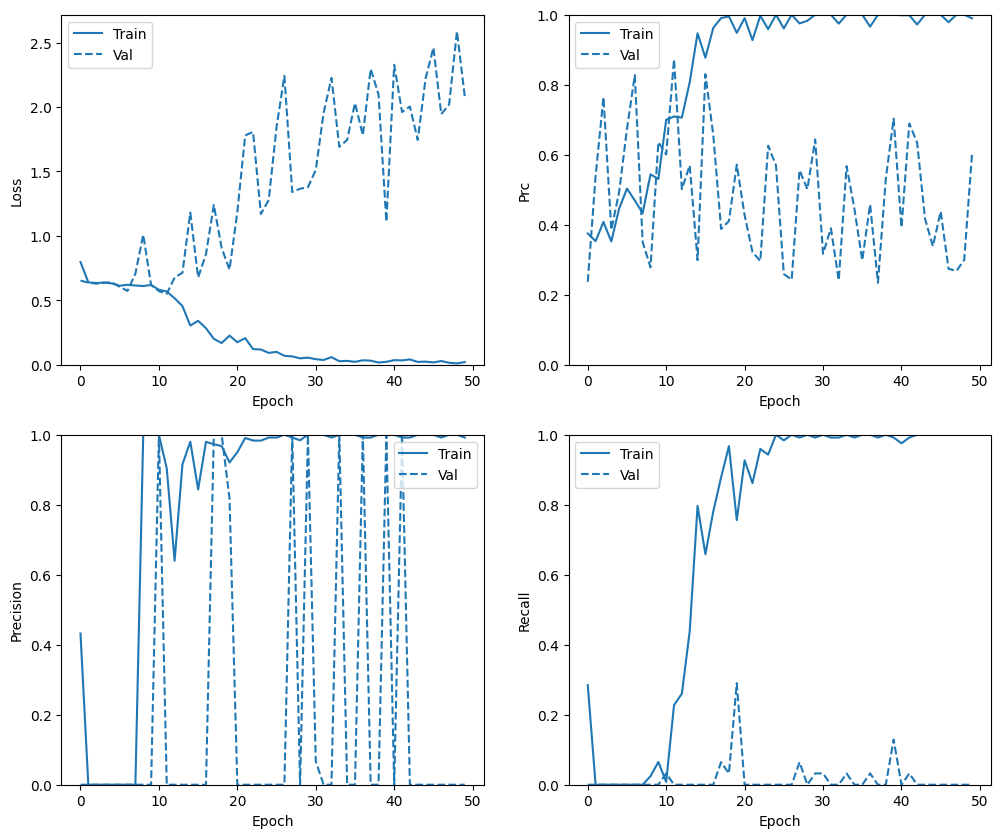

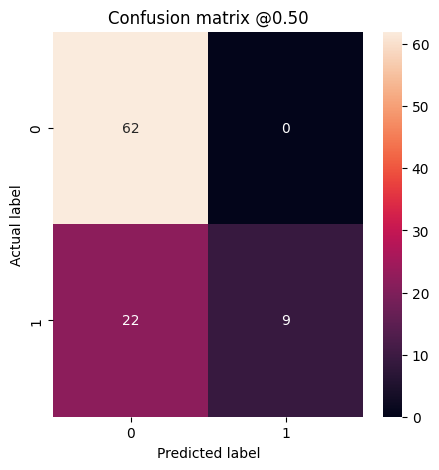

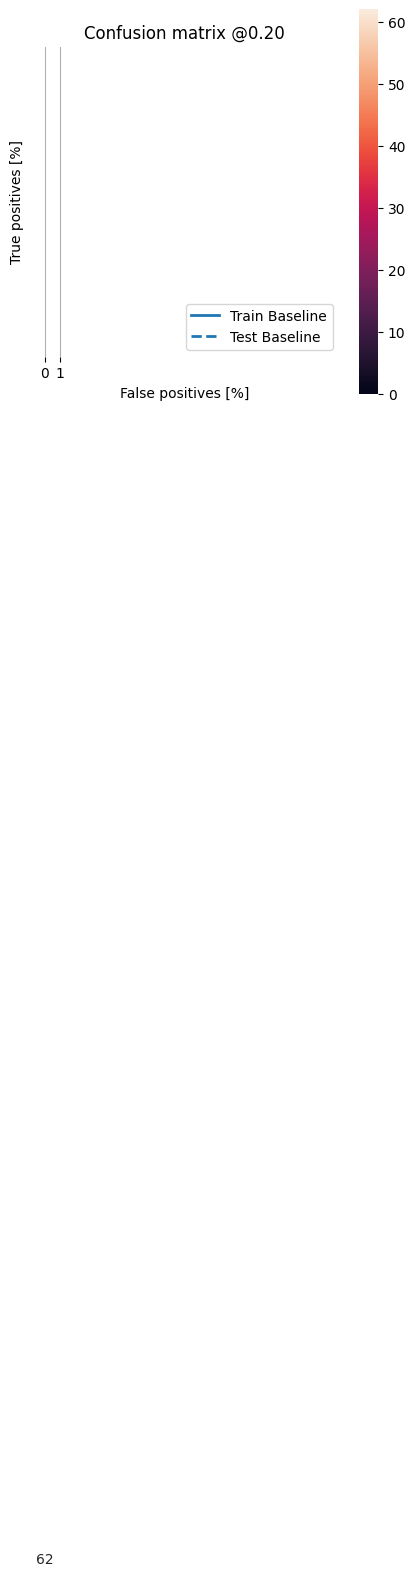

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(baseline_history)

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

train_predictions_baseline = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(val_ds, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=1)

test_labels = np.concatenate([y for x, y in val_ds], axis=0)

plot_cm(test_labels, test_predictions_baseline)

# Lower threshold means higher cost for false negatives (Event not detected while it is)

plot_cm(test_labels, test_predictions_baseline, threshold=0.2)

import sklearn

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  
plot_roc("Train Baseline", np.concatenate([y for x, y in train_ds], axis=0), train_predictions_baseline, color=colors[0])

plot_roc("Test Baseline", np.concatenate([y for x, y in val_ds], axis=0), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')